In [1]:
# %%
import os
import logging
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Configure logging to print in notebook
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")


In [2]:
# %%
def load_data(X_path="X.npy", y_path="y.npy"):
    if not os.path.exists(X_path) or not os.path.exists(y_path):
        raise FileNotFoundError(f"Missing {X_path} or {y_path}")
    X = np.load(X_path)
    y = np.load(y_path)
    logging.info(f"Loaded X shape: {X.shape}, y shape: {y.shape}")
    if X.ndim != 2:
        raise ValueError(f"Expected X to be 2D (n_samples, n_features), got shape {X.shape}")
    if y.ndim != 1 or y.shape[0] != X.shape[0]:
        raise ValueError(f"y must be 1D with same length as X; got y.shape={y.shape}")
    return X, y

# Load
X, y = load_data("X.npy", "y.npy")

# Inspect a few entries
print("Example feature vector (first sample):", X[0][:5], "...")  # first 5 values
print("Example label (first sample):", y[0])


2025-06-24 17:25:26,641 [INFO] Loaded X shape: (304, 172), y shape: (304,)


Example feature vector (first sample): [0.002882 0.003058 0.003172 0.00325  0.003746] ...
Example label (first sample): 0


In [3]:
# %%
unique, counts = np.unique(y, return_counts=True)
logging.info(f"Overall class distribution: {dict(zip(unique, counts))}")


2025-06-24 17:25:46,134 [INFO] Overall class distribution: {np.int64(0): np.int64(148), np.int64(1): np.int64(156)}


In [4]:
# %%
def preprocess(X, y, test_size=0.2, val_size=0.1, random_state=42):
    n_samples, n_features = X.shape
    # Reshape
    X_cnn = X.reshape((n_samples, n_features, 1))
    logging.info(f"Reshaped X to {X_cnn.shape} for Conv1D")

    # Split train+val vs test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_cnn, y, test_size=test_size, random_state=random_state, stratify=y
    )
    # Split train vs val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_size, random_state=random_state, stratify=y_trainval
    )
    logging.info(f"Split sizes: train={X_train.shape[0]}, val={X_val.shape[0]}, test={X_test.shape[0]}")

    # Standardize per feature index using training set
    def scale_split(X_split, scaler=None):
        n, L, _ = X_split.shape
        flat = X_split.reshape((n, L))
        if scaler is None:
            scaler = StandardScaler()
            flat_scaled = scaler.fit_transform(flat)
        else:
            flat_scaled = scaler.transform(flat)
        X_scaled = flat_scaled.reshape((n, L, 1))
        return X_scaled, scaler

    X_train_scaled, scaler = scale_split(X_train)
    X_val_scaled, _ = scale_split(X_val, scaler=scaler)
    X_test_scaled, _ = scale_split(X_test, scaler=scaler)
    logging.info("Standardization done based on training set.")
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler

# Run preprocessing
X_train, X_val, X_test, y_train, y_val, y_test, scaler = preprocess(X, y)
print("Shapes after preprocessing:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val:", X_val.shape, "y_val:", y_val.shape)
print("  X_test:", X_test.shape, "y_test:", y_test.shape)


2025-06-24 17:25:57,346 [INFO] Reshaped X to (304, 172, 1) for Conv1D
2025-06-24 17:25:57,352 [INFO] Split sizes: train=218, val=25, test=61
2025-06-24 17:25:57,354 [INFO] Standardization done based on training set.


Shapes after preprocessing:
  X_train: (218, 172, 1) y_train: (218,)
  X_val: (25, 172, 1) y_val: (25,)
  X_test: (61, 172, 1) y_test: (61,)


In [5]:
# %%
def compute_class_weights(y_train):
    classes = np.unique(y_train)
    cw = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, cw))
    logging.info(f"Class weights: {class_weights}")
    return class_weights

class_weights = compute_class_weights(y_train)


2025-06-24 17:26:18,268 [INFO] Class weights: {np.int64(0): np.float64(1.028301886792453), np.int64(1): np.float64(0.9732142857142857)}


In [6]:
# %%
def build_1d_cnn(input_shape):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

input_shape = X_train.shape[1:]  # (length, 1)
model = build_1d_cnn(input_shape)
model.summary()


/Users/jessecox/.pyenv/versions/3.11.2/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 170, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 85, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 83, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 39, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2432)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       155,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,817 (729.75 KB)

 Trainable params: 186,817 (729.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# %%
# Callbacks
model_dir = "model_checkpoints"
os.makedirs(model_dir, exist_ok=True)
checkpoint_path = os.path.join(model_dir, "best_model.h5")

es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mc = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', mode='max',
                               save_best_only=True, verbose=1)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    #callbacks=[es, mc],
    class_weight=class_weights,
    verbose=2
)


Epoch 1/50
7/7 - 0s - 10ms/step - accuracy: 0.8853 - auc: 0.9499 - loss: 0.2898 - val_accuracy: 0.8000 - val_auc: 0.8846 - val_loss: 0.4826
Epoch 2/50
7/7 - 0s - 7ms/step - accuracy: 0.8945 - auc: 0.9518 - loss: 0.2892 - val_accuracy: 0.7600 - val_auc: 0.8942 - val_loss: 0.4232
Epoch 3/50
7/7 - 0s - 7ms/step - accuracy: 0.8945 - auc: 0.9623 - loss: 0.2632 - val_accuracy: 0.8000 - val_auc: 0.8910 - val_loss: 0.4186
Epoch 4/50
7/7 - 0s - 6ms/step - accuracy: 0.9266 - auc: 0.9690 - loss: 0.2365 - val_accuracy: 0.7600 - val_auc: 0.9071 - val_loss: 0.3905
Epoch 5/50
7/7 - 0s - 6ms/step - accuracy: 0.9083 - auc: 0.9599 - loss: 0.2573 - val_accuracy: 0.8000 - val_auc: 0.8974 - val_loss: 0.4445
Epoch 6/50
7/7 - 0s - 6ms/step - accuracy: 0.9220 - auc: 0.9646 - loss: 0.2470 - val_accuracy: 0.7600 - val_auc: 0.8974 - val_loss: 0.4216
Epoch 7/50
7/7 - 0s - 6ms/step - accuracy: 0.8853 - auc: 0.9568 - loss: 0.2779 - val_accuracy: 0.8000 - val_auc: 0.8910 - val_loss: 0.4482
Epoch 8/50
7/7 - 0s - 6ms/

In [13]:
# %%
# Load best weights and evaluate
model.load_weights(checkpoint_path)
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}")


2/2 - 0s - 11ms/step - accuracy: 0.9016 - auc: 0.9667 - loss: 0.2722
Test loss: 0.2722, accuracy: 0.9016, AUC: 0.9667


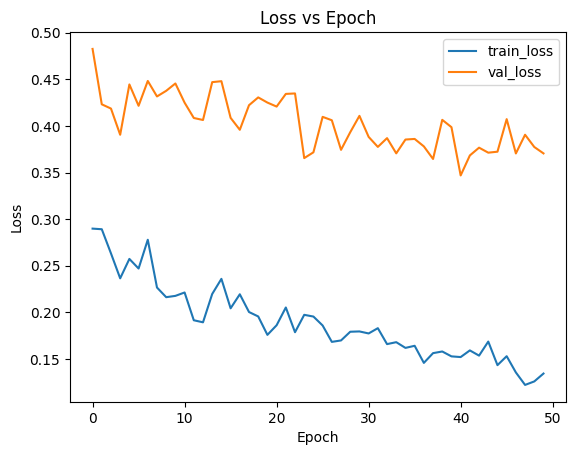

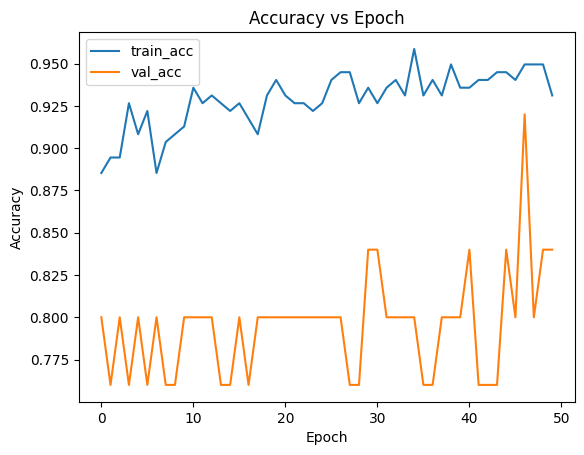

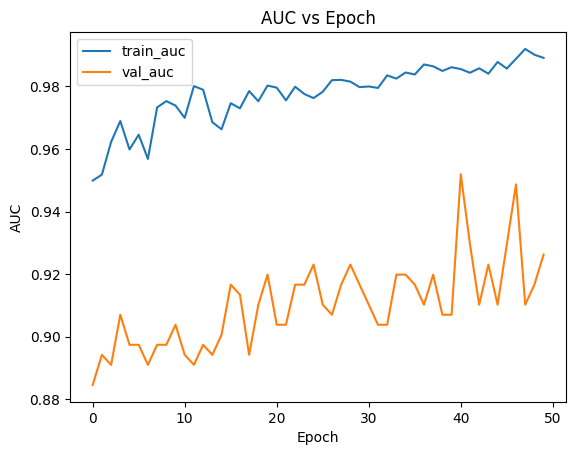

In [14]:
# %%
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epoch')
plt.show()

# Plot AUC
plt.figure()
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC vs Epoch')
plt.show()


In [10]:
# %%
# Save the final model (best weights already loaded)
final_model_path = "spectral_1d_cnn.h5"
model.save(final_model_path)
logging.info(f"Saved final model to {final_model_path}")

# Save scaler for inference later
import joblib
scaler_path = "scaler.joblib"
joblib.dump(scaler, scaler_path)
logging.info(f"Saved StandardScaler to {scaler_path}")


2025-06-24 17:28:40,838 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-06-24 17:28:40,866 [INFO] Saved final model to spectral_1d_cnn.h5
2025-06-24 17:28:40,868 [INFO] Saved StandardScaler to scaler.joblib


In [11]:
# %%
# Example function for inference on new spectral vector
def predict_sample(sample_flat, model_path="spectral_1d_cnn.h5", scaler_path="scaler.joblib"):
    """
    sample_flat: 1D numpy array of length n_features
    Returns predicted probability of class 1.
    """
    # Load
    model = tf.keras.models.load_model(model_path)
    scaler = joblib.load(scaler_path)
    # Preprocess: reshape and scale
    sample_flat = np.nan_to_num(sample_flat, nan=0.0)
    flat_scaled = scaler.transform(sample_flat.reshape(1, -1))
    sample_cnn = flat_scaled.reshape((1, flat_scaled.shape[1], 1))
    prob = model.predict(sample_cnn)[0,0]
    return prob

# Example usage (uncomment and replace with actual data):
# new_vec = X[0]  # or any new spectral vector
# print("Predicted probability:", predict_sample(new_vec))
